## Tradingview casero

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import jarque_bera
import cvxpy as cp
from cvxopt import matrix, solvers
import requests
import json
import urllib3
urllib3.disable_warnings()
from datetime import datetime
import pytz

In [1]:
df_ggal = dfs['GGAL']
df_ggal

NameError: name 'dfs' is not defined

In [ ]:
df_ggal.to_csv('ggal_data.csv', index=False)

In [5]:
# Cargar el DataFrame
df_ggal = pd.read_csv('/Users/juanpablomigani/Desktop/Facultad/Trabajo final Diplomatura Data Science/Trabajo/Datos/ggal_data.csv')
df_ggal

,status,timestamp,close,open,high,low,volume
0,ok,2022-08-01,220.00,240.0,240.0,217.0,61043
1,ok,2022-08-02,224.10,221.0,225.0,217.5,143349
2,ok,2022-08-03,226.25,228.0,228.0,221.0,36800
3,ok,2022-08-04,223.05,230.0,230.0,220.0,34749
4,ok,2022-08-05,222.65,225.0,226.0,220.6,34686
...,...,...,...,...,...,...,...
513,ok,2024-09-09,5230.00,5290.0,5370.0,5190.0,81044
514,ok,2024-09-10,5150.00,5300.0,5310.0,5020.0,55764
515,ok,2024-09-11,5350.00,5170.0,5490.0,5140.0,84805
516,ok,2024-09-12,5430.00,5410.0,5510.0,5390.0,53980


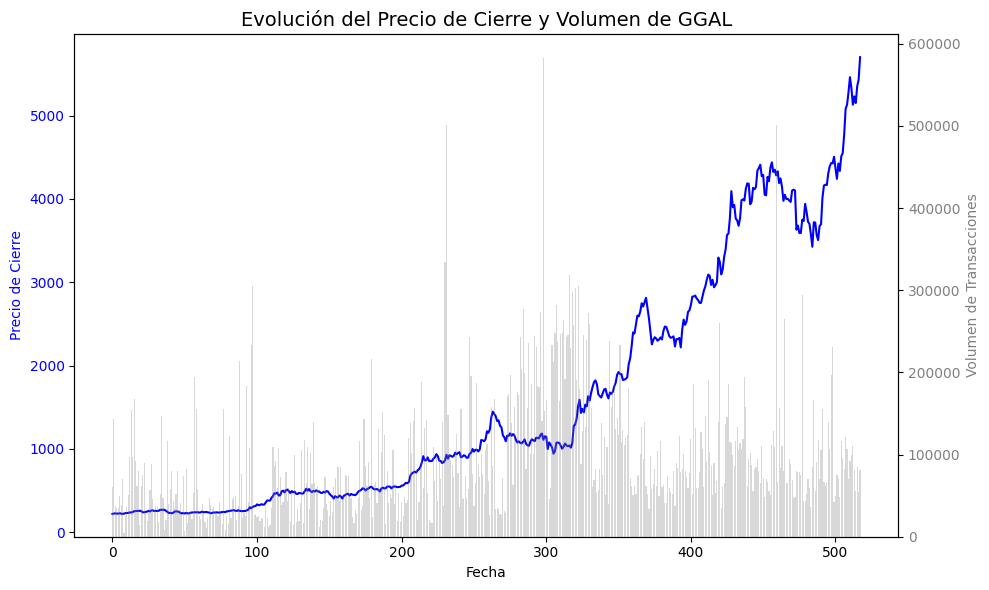

In [9]:
# Graficar los datos de precio de cierre junto con el volumen de transacciones
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar precio de cierre
ax1.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio de Cierre', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear otro eje para el volumen de transacciones
ax2 = ax1.twinx()
ax2.bar(df_ggal.index, df_ggal['volume'], label='Volumen de Transacciones', color='gray', alpha=0.3)
ax2.set_ylabel('Volumen de Transacciones', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Título y leyenda
plt.title('Evolución del Precio de Cierre y Volumen de GGAL', fontsize=14)
fig.tight_layout()  # Asegura que no se superpongan las etiquetas

# Mostrar gráfico
plt.show()

In [10]:
# Convertir la columna 'timestamp' a formato de fecha
df_ggal['timestamp'] = pd.to_datetime(df_ggal['timestamp'])

# Establecer el índice del DataFrame en la columna 'timestamp'
df_ggal.set_index('timestamp', inplace=True)

# Crear columnas de promedio semanal, mensual y trimestral
# Usamos el precio de cierre para calcular estos promedios

# Promedio semanal
df_ggal['Weekly_Avg'] = df_ggal['close'].resample('W').transform('mean')

# Promedio mensual
df_ggal['Monthly_Avg'] = df_ggal['close'].resample('ME').transform('mean')

# Promedio trimestral
df_ggal['Quarterly_Avg'] = df_ggal['close'].resample('QE').transform('mean')

# Visualizar las primeras filas con los nuevos promedios
df_ggal[['close', 'Weekly_Avg', 'Monthly_Avg', 'Quarterly_Avg']].head()

,close,Weekly_Avg,Monthly_Avg,Quarterly_Avg
timestamp,,,,
2022-08-01,220.00,223.21,235.5,243.339535
2022-08-02,224.10,223.21,235.5,243.339535
2022-08-03,226.25,223.21,235.5,243.339535
2022-08-04,223.05,223.21,235.5,243.339535
2022-08-05,222.65,223.21,235.5,243.339535


In [11]:
# Agregar columnas de volatilidad (desviación estándar) semanal, mensual y trimestral

# Volatilidad semanal
df_ggal['Weekly_Volatility'] = df_ggal['close'].rolling(window=7).std()

# Volatilidad mensual
df_ggal['Monthly_Volatility'] = df_ggal['close'].rolling(window=30).std()

# Volatilidad trimestral
df_ggal['Quarterly_Volatility'] = df_ggal['close'].rolling(window=90).std()

# Mostrar las filas a partir del día 100 para verificar los cálculos
df_ggal[['close', 'Weekly_Volatility', 'Monthly_Volatility', 'Quarterly_Volatility']].iloc[100:110]

,close,Weekly_Volatility,Monthly_Volatility,Quarterly_Volatility
timestamp,,,,
2022-12-28,334.25,20.218821,25.743773,19.917965
2022-12-29,324.20,15.414302,27.525500,21.294244
2022-12-30,326.55,15.395141,29.169220,22.676090
2023-01-02,336.55,12.084657,30.983796,24.297636
2023-01-03,331.00,9.493306,32.002481,25.608376
2023-01-04,331.50,7.492870,32.823649,26.870141
2023-01-05,356.10,10.496882,34.979436,28.899195
2023-01-06,381.10,20.563378,38.595759,31.752951
2023-01-09,380.00,23.562220,41.170291,34.267271


In [12]:
# Agregar columnas de rendimientos acumulados semanal, mensual y trimestral

# Rendimiento semanal acumulado
df_ggal['Weekly_Return'] = df_ggal['close'].pct_change(periods=7) * 100

# Rendimiento mensual acumulado
df_ggal['Monthly_Return'] = df_ggal['close'].pct_change(periods=30) * 100

# Rendimiento trimestral acumulado
df_ggal['Quarterly_Return'] = df_ggal['close'].pct_change(periods=90) * 100

# Mostrar las filas a partir del punto donde empiezan a aparecer los rendimientos acumulados
df_ggal[['close', 'Weekly_Return', 'Monthly_Return', 'Quarterly_Return']].dropna().head(10)

,close,Weekly_Return,Monthly_Return,Quarterly_Return
timestamp,,,,
2022-12-14,252.50,-3.607559,7.332625,14.772727
2022-12-15,254.50,-3.835254,6.708595,13.565373
2022-12-16,255.35,-0.931135,3.569256,12.861878
2022-12-19,262.70,2.999412,8.936347,17.776283
2022-12-20,270.70,2.344045,12.557173,21.580957
2022-12-21,299.00,17.554551,22.969360,31.747081
2022-12-22,288.55,12.780926,21.239496,29.423638
2022-12-23,303.85,20.336634,29.133022,37.988193
2022-12-26,311.95,22.573674,37.060633,39.637422


In [13]:
df_ggal

,status,close,open,high,low,volume,Weekly_Avg,Monthly_Avg,Quarterly_Avg,Weekly_Volatility,Monthly_Volatility,Quarterly_Volatility,Weekly_Return,Monthly_Return,Quarterly_Return
timestamp,,,,,,,,,,,,,,,
2022-08-01,ok,220.00,240.0,240.0,217.0,61043,223.21,235.5,243.339535,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-02,ok,224.10,221.0,225.0,217.5,143349,223.21,235.5,243.339535,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-03,ok,226.25,228.0,228.0,221.0,36800,223.21,235.5,243.339535,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-04,ok,223.05,230.0,230.0,220.0,34749,223.21,235.5,243.339535,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-05,ok,222.65,225.0,226.0,220.6,34686,223.21,235.5,243.339535,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-09,ok,5230.00,5290.0,5370.0,5190.0,81044,5372.00,5319.0,4265.958333,134.022031,584.835668,435.779606,9.643606,46.498599,58.355285
2024-09-10,ok,5150.00,5300.0,5310.0,5020.0,55764,5372.00,5319.0,4265.958333,122.726952,571.330495,441.746270,1.377953,50.364964,51.836783
2024-09-11,ok,5350.00,5170.0,5490.0,5140.0,84805,5372.00,5319.0,4265.958333,116.598620,577.235509,455.175417,4.288499,43.817204,49.964961


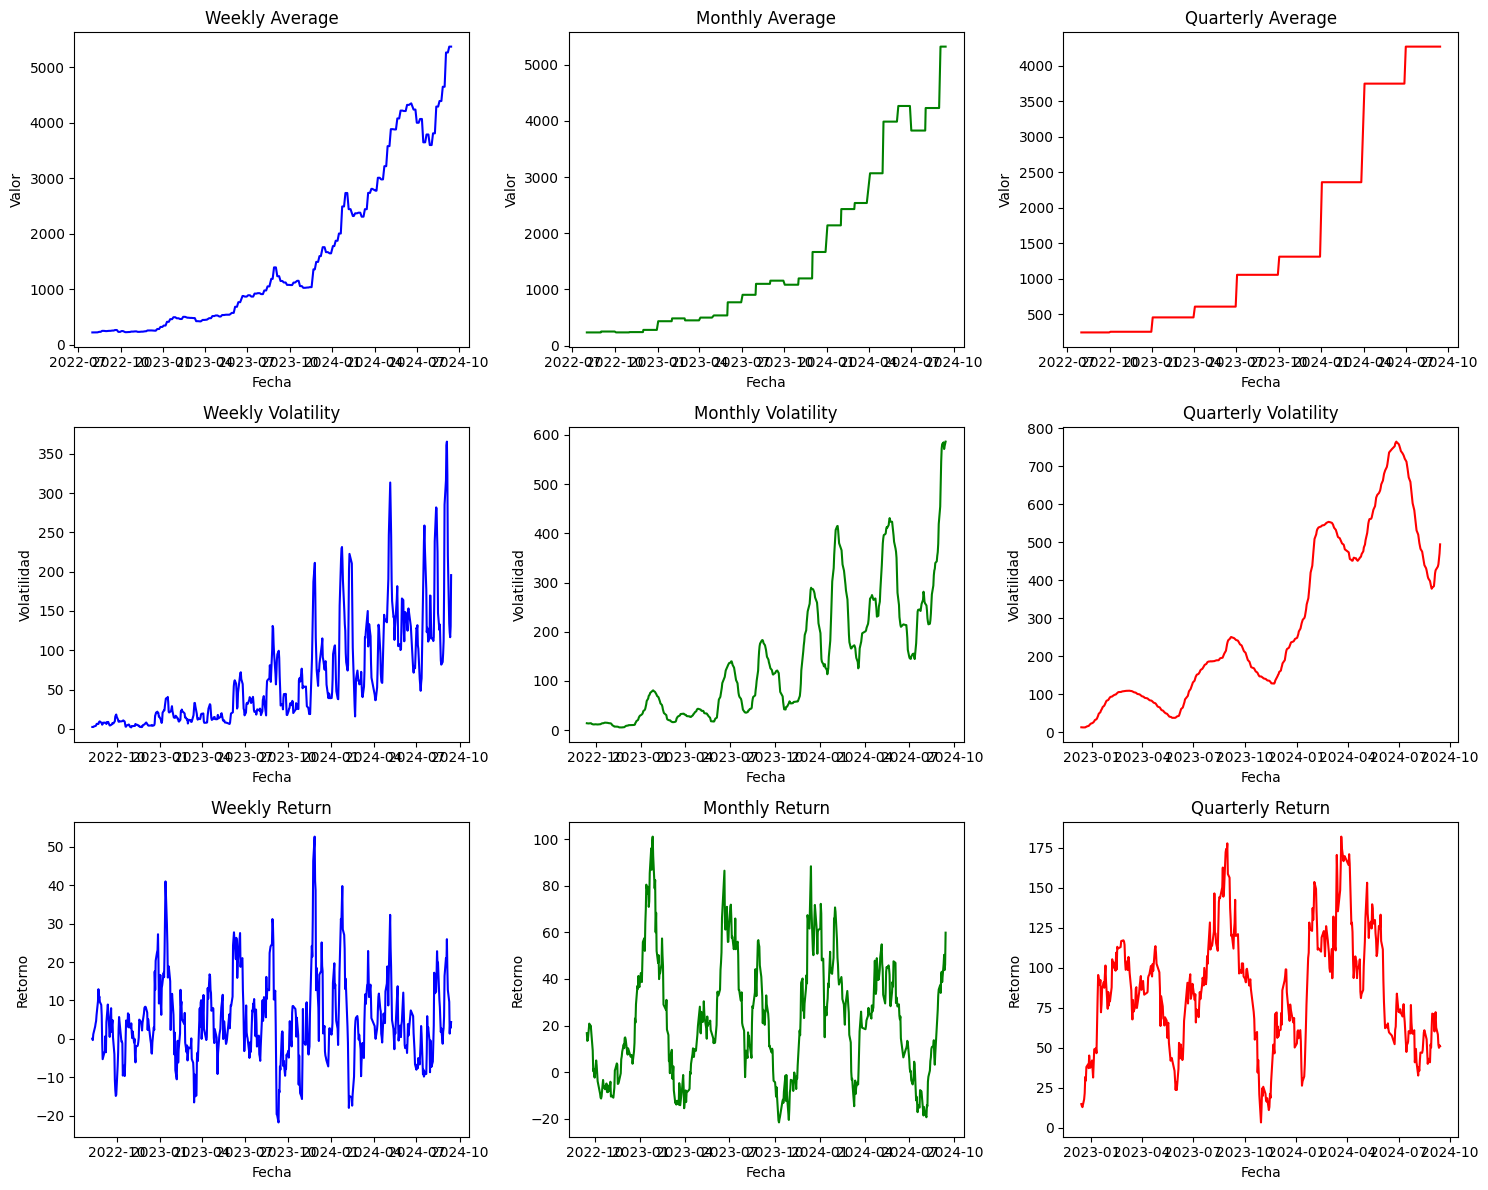

In [14]:
# Seleccionar las columnas relevantes para graficar
columns_to_plot = ['Weekly_Avg', 'Monthly_Avg', 'Quarterly_Avg', 
                   'Weekly_Volatility', 'Monthly_Volatility', 'Quarterly_Volatility', 
                   'Weekly_Return', 'Monthly_Return', 'Quarterly_Return']

# Crear subplots para las columnas
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# Graficar los promedios (Weekly_Avg, Monthly_Avg, Quarterly_Avg)
axs[0, 0].plot(df_ggal.index, df_ggal['Weekly_Avg'], label='Weekly Avg', color='blue')
axs[0, 0].set_title('Weekly Average')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('Valor')

axs[0, 1].plot(df_ggal.index, df_ggal['Monthly_Avg'], label='Monthly Avg', color='green')
axs[0, 1].set_title('Monthly Average')
axs[0, 1].set_xlabel('Fecha')
axs[0, 1].set_ylabel('Valor')

axs[0, 2].plot(df_ggal.index, df_ggal['Quarterly_Avg'], label='Quarterly Avg', color='red')
axs[0, 2].set_title('Quarterly Average')
axs[0, 2].set_xlabel('Fecha')
axs[0, 2].set_ylabel('Valor')

# Graficar las volatilidades (Weekly_Volatility, Monthly_Volatility, Quarterly_Volatility)
axs[1, 0].plot(df_ggal.index, df_ggal['Weekly_Volatility'], label='Weekly Volatility', color='blue')
axs[1, 0].set_title('Weekly Volatility')
axs[1, 0].set_xlabel('Fecha')
axs[1, 0].set_ylabel('Volatilidad')

axs[1, 1].plot(df_ggal.index, df_ggal['Monthly_Volatility'], label='Monthly Volatility', color='green')
axs[1, 1].set_title('Monthly Volatility')
axs[1, 1].set_xlabel('Fecha')
axs[1, 1].set_ylabel('Volatilidad')

axs[1, 2].plot(df_ggal.index, df_ggal['Quarterly_Volatility'], label='Quarterly Volatility', color='red')
axs[1, 2].set_title('Quarterly Volatility')
axs[1, 2].set_xlabel('Fecha')
axs[1, 2].set_ylabel('Volatilidad')

# Graficar los retornos (Weekly_Return, Monthly_Return, Quarterly_Return)
axs[2, 0].plot(df_ggal.index, df_ggal['Weekly_Return'], label='Weekly Return', color='blue')
axs[2, 0].set_title('Weekly Return')
axs[2, 0].set_xlabel('Fecha')
axs[2, 0].set_ylabel('Retorno')

axs[2, 1].plot(df_ggal.index, df_ggal['Monthly_Return'], label='Monthly Return', color='green')
axs[2, 1].set_title('Monthly Return')
axs[2, 1].set_xlabel('Fecha')
axs[2, 1].set_ylabel('Retorno')

axs[2, 2].plot(df_ggal.index, df_ggal['Quarterly_Return'], label='Quarterly Return', color='red')
axs[2, 2].set_title('Quarterly Return')
axs[2, 2].set_xlabel('Fecha')
axs[2, 2].set_ylabel('Retorno')

# Ajustar el layout
plt.tight_layout()
plt.show()

### Medias móviles

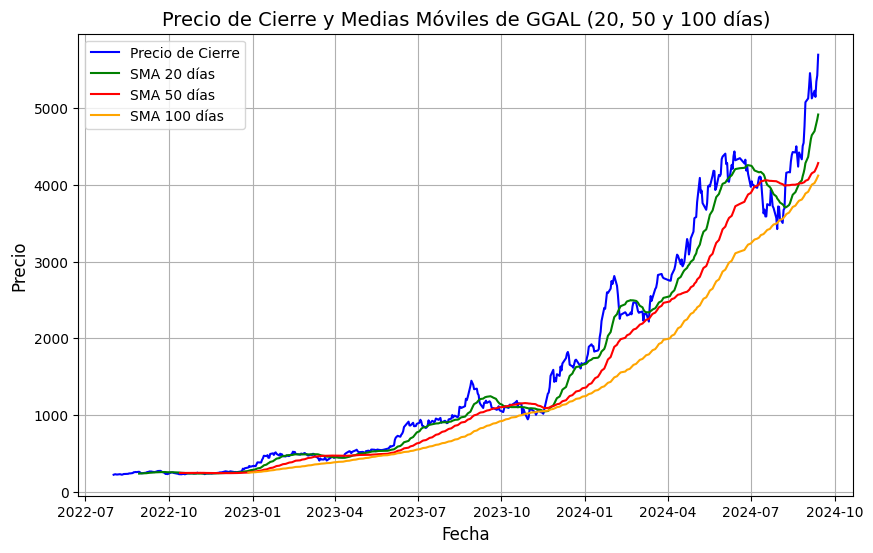

In [15]:
# Calcular medias móviles de 20 y 50 días
df_ggal['SMA_20'] = df_ggal['close'].rolling(window=20).mean()
df_ggal['SMA_50'] = df_ggal['close'].rolling(window=50).mean()
# Calcular media móvil de 100 días
df_ggal['SMA_100'] = df_ggal['close'].rolling(window=100).mean()

# Graficar el precio de cierre y las medias móviles
plt.figure(figsize=(10, 6))

# Precio de cierre
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')

# Medias móviles
plt.plot(df_ggal.index, df_ggal['SMA_20'], label='SMA 20 días', color='green')
plt.plot(df_ggal.index, df_ggal['SMA_50'], label='SMA 50 días', color='red')
plt.plot(df_ggal.index, df_ggal['SMA_100'], label='SMA 100 días', color='orange')

# Etiquetas y título
plt.title('Precio de Cierre y Medias Móviles de GGAL (20, 50 y 100 días)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Bandas de Bollinger

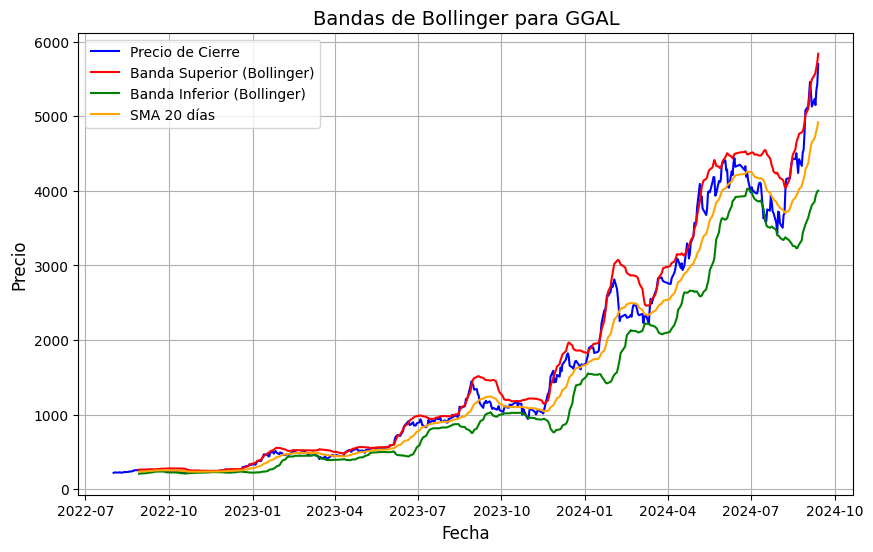

In [16]:
# Calcular las Bandas de Bollinger
# Usaremos una media móvil de 20 días y una desviación estándar de 2
df_ggal['SMA_20'] = df_ggal['close'].rolling(window=20).mean()
df_ggal['STD_20'] = df_ggal['close'].rolling(window=20).std()

# Bandas de Bollinger
df_ggal['Upper_Band'] = df_ggal['SMA_20'] + (df_ggal['STD_20'] * 2)
df_ggal['Lower_Band'] = df_ggal['SMA_20'] - (df_ggal['STD_20'] * 2)

# Graficar las Bandas de Bollinger junto con el precio de cierre
plt.figure(figsize=(10, 6))

# Precio de cierre
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')

# Bandas de Bollinger
plt.plot(df_ggal.index, df_ggal['Upper_Band'], label='Banda Superior (Bollinger)', color='red')
plt.plot(df_ggal.index, df_ggal['Lower_Band'], label='Banda Inferior (Bollinger)', color='green')

# Media móvil de 20 días
plt.plot(df_ggal.index, df_ggal['SMA_20'], label='SMA 20 días', color='orange')

# Etiquetas y título
plt.title('Bandas de Bollinger para GGAL', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### RSI (Relative Strength Index)

El RSI se calcula utilizando el cambio promedio de los precios de cierre en los días en los que el precio sube y baja. Se define en un rango de 0 a 100, donde:

- RSI > 70: Señal de sobrecompra.
- RSI < 30: Señal de sobreventa.

El gráfico con el precio de cierre y el RSI (Relative Strength Index) de GGAL. El RSI se muestra en el gráfico inferior, con las líneas marcando los niveles de sobrecompra (70) y sobreventa (30).

El RSI te permite identificar momentos en los que el activo puede estar sobrecomprado o sobrevendido, ofreciendo señales potenciales de compra o venta.

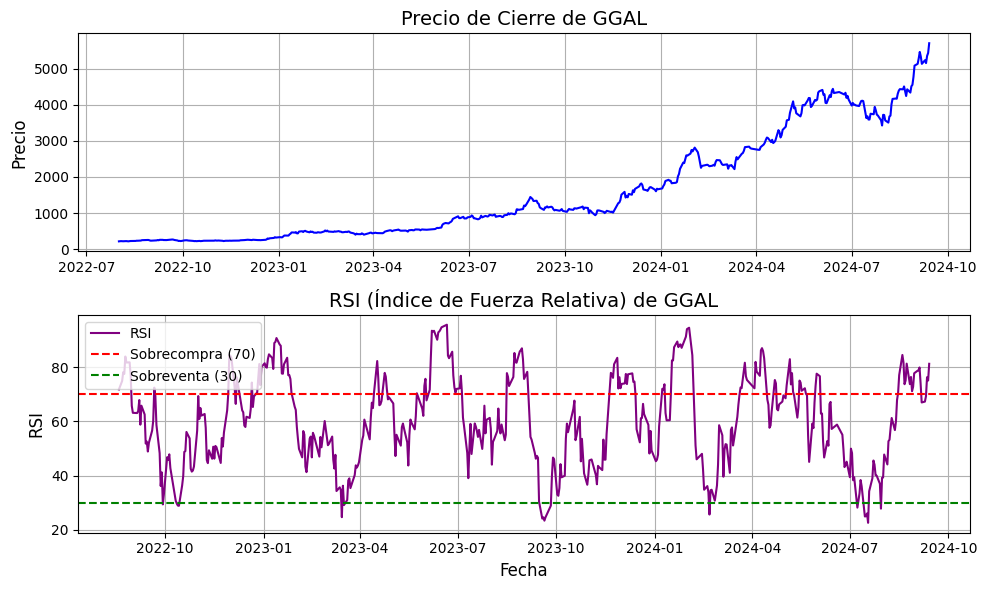

In [17]:
# Calcular el RSI (Relative Strength Index) para GGAL
# Periodo típico de 14 días
periodo_rsi = 14

# Cambios en el precio de cierre entre días consecutivos
delta = df_ggal['close'].diff()

# Ganancias y pérdidas separadas
ganancia = delta.where(delta > 0, 0)
perdida = -delta.where(delta < 0, 0)

# Promedio de ganancias y pérdidas
promedio_ganancia = ganancia.rolling(window=periodo_rsi).mean()
promedio_perdida = perdida.rolling(window=periodo_rsi).mean()

# Ratio de Fuerza Relativa (Relative Strength, RS)
rs = promedio_ganancia / promedio_perdida

# Índice de Fuerza Relativa (RSI)
df_ggal['RSI'] = 100 - (100 / (1 + rs))

# Graficar el RSI junto con el precio de cierre
plt.figure(figsize=(10, 6))

# Subplot para el precio de cierre
plt.subplot(2, 1, 1)
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de GGAL', fontsize=14)
plt.ylabel('Precio', fontsize=12)
plt.grid(True)

# Subplot para el RSI
plt.subplot(2, 1, 2)
plt.plot(df_ggal.index, df_ggal['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Sobrecompra (70)')
plt.axhline(30, color='green', linestyle='--', label='Sobreventa (30)')
plt.title('RSI (Índice de Fuerza Relativa) de GGAL', fontsize=14)
plt.ylabel('RSI', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.grid(True)
plt.legend()

# Ajustar y mostrar el gráfico
plt.tight_layout()
plt.show()

### MACD (Moving Average Convergence Divergence)

El MACD (Moving Average Convergence Divergence). Este indicador se basa en la diferencia entre dos medias móviles exponenciales (EMA), normalmente de 12 y 26 días, junto con una línea de señal de 9 días para detectar cambios en la fuerza y la dirección de la tendencia.

Fórmula del MACD:
- Línea MACD = EMA(12) - EMA(26)
- Línea de señal = EMA de 9 días de la Línea MACD
- Histograma = Línea MACD - Línea de señal

El MACD ayuda a identificar cambios en la fuerza, dirección, impulso y duración de una tendencia en los precios.

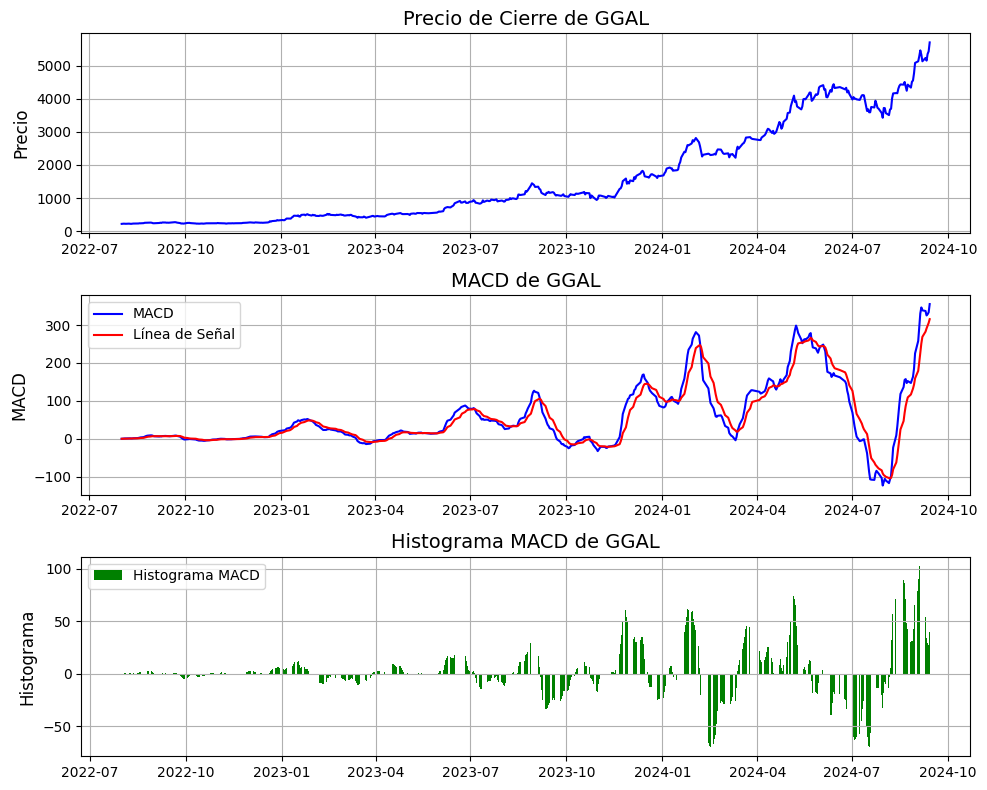

In [18]:
# Calcular el MACD (Moving Average Convergence Divergence)
# Parámetros típicos
ema_12 = df_ggal['close'].ewm(span=12, adjust=False).mean()
ema_26 = df_ggal['close'].ewm(span=26, adjust=False).mean()

# Línea MACD
df_ggal['MACD'] = ema_12 - ema_26

# Línea de señal
df_ggal['Signal_Line'] = df_ggal['MACD'].ewm(span=9, adjust=False).mean()

# Histograma MACD
df_ggal['MACD_Histogram'] = df_ggal['MACD'] - df_ggal['Signal_Line']

# Graficar el MACD
plt.figure(figsize=(10, 8))

# Subplot para el precio de cierre
plt.subplot(3, 1, 1)
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de GGAL', fontsize=14)
plt.ylabel('Precio', fontsize=12)
plt.grid(True)

# Subplot para el MACD
plt.subplot(3, 1, 2)
plt.plot(df_ggal.index, df_ggal['MACD'], label='MACD', color='blue')
plt.plot(df_ggal.index, df_ggal['Signal_Line'], label='Línea de Señal', color='red')
plt.title('MACD de GGAL', fontsize=14)
plt.ylabel('MACD', fontsize=12)
plt.grid(True)
plt.legend()

# Subplot para el histograma
plt.subplot(3, 1, 3)
plt.bar(df_ggal.index, df_ggal['MACD_Histogram'], label='Histograma MACD', color='green')
plt.title('Histograma MACD de GGAL', fontsize=14)
plt.ylabel('Histograma', fontsize=12)
plt.grid(True)
plt.legend()

# Ajustar el gráfico
plt.tight_layout()
plt.show()

### ATR (Average True Range)

El ATR (Average True Range) mide la volatilidad de un activo, calculando la diferencia entre los precios altos y bajos en un periodo determinado. A diferencia de otros indicadores, el ATR no indica la dirección del movimiento, sino la magnitud del rango.

La fórmula del ATR se basa en el True Range (Rango Verdadero), que es el mayor de los siguientes valores:

1. High - Low (Rango del día)
2. |High - Close del día anterior|
3. |Low - Close del día anterior|

Luego, se toma un promedio móvil exponencial de este valor para obtener el ATR.

El gráfico del ATR (Average True Range) de GGAL, que mide la volatilidad del precio. El primer gráfico muestra el precio de cierre, y el segundo gráfico muestra el ATR calculado con un periodo de 14 días.

El ATR te permite observar los momentos en los que la acción es más o menos volátil.

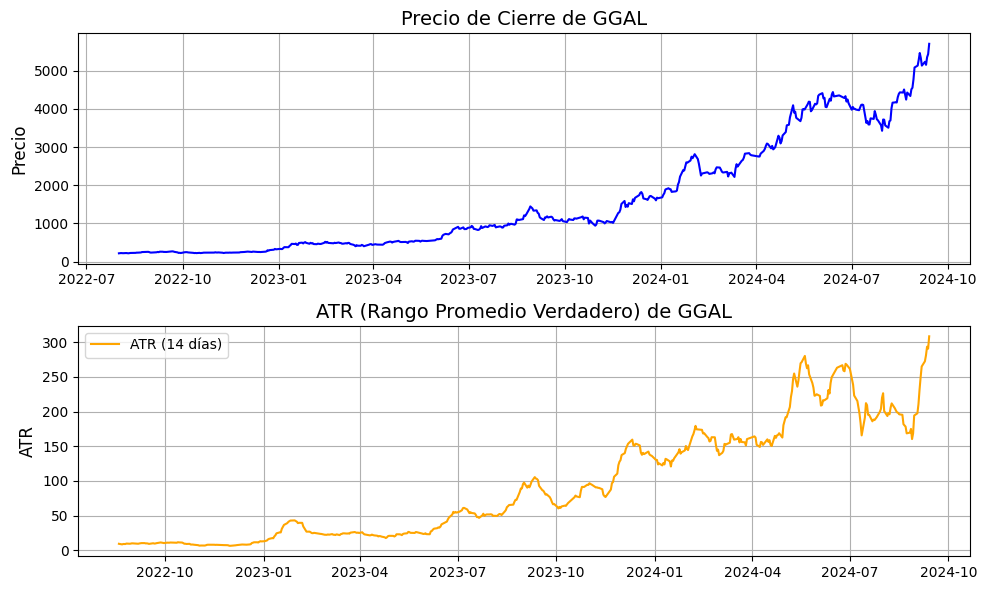

In [19]:
# Calcular el Rango Verdadero (True Range)
df_ggal['High_Low'] = df_ggal['high'] - df_ggal['low']
df_ggal['High_Close_Prev'] = (df_ggal['high'] - df_ggal['close'].shift()).abs()
df_ggal['Low_Close_Prev'] = (df_ggal['low'] - df_ggal['close'].shift()).abs()

# El Rango Verdadero es el máximo de los tres valores
df_ggal['True_Range'] = df_ggal[['High_Low', 'High_Close_Prev', 'Low_Close_Prev']].max(axis=1)

# Calcular el ATR (Average True Range) con un periodo de 14 días
df_ggal['ATR'] = df_ggal['True_Range'].rolling(window=14).mean()

# Graficar el ATR junto con el precio de cierre
plt.figure(figsize=(10, 6))

# Subplot para el precio de cierre
plt.subplot(2, 1, 1)
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de GGAL', fontsize=14)
plt.ylabel('Precio', fontsize=12)
plt.grid(True)

# Subplot para el ATR
plt.subplot(2, 1, 2)
plt.plot(df_ggal.index, df_ggal['ATR'], label='ATR (14 días)', color='orange')
plt.title('ATR (Rango Promedio Verdadero) de GGAL', fontsize=14)
plt.ylabel('ATR', fontsize=12)
plt.grid(True)
plt.legend()

# Ajustar el gráfico
plt.tight_layout()
plt.show()

### ADX (Average Directional Index)

El ADX (Average Directional Index) mide la fuerza de una tendencia, independientemente de su dirección. Se calcula a partir de los indicadores de movimiento direccional +DI y -DI.

El gráfico del ADX (Average Directional Index) para GGAL, que mide la fuerza de la tendencia. El primer gráfico muestra el precio de cierre, mientras que el segundo gráfico muestra el ADX, donde un valor superior a 25 indica una tendencia fuerte, independientemente de la dirección.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


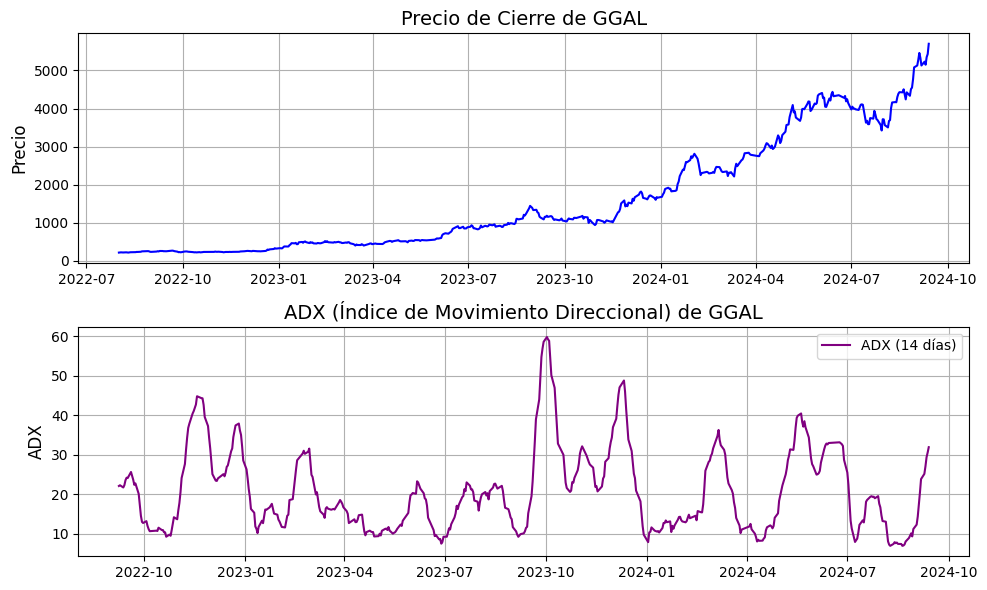

In [20]:
# Calcular +DI y -DI
df_ggal['High_Diff'] = df_ggal['high'].diff()
df_ggal['Low_Diff'] = df_ggal['low'].diff()

# Calcular +DM y -DM (Directional Movement)
df_ggal['+DM'] = df_ggal['High_Diff'].where((df_ggal['High_Diff'] > df_ggal['Low_Diff']) & (df_ggal['High_Diff'] > 0), 0)
df_ggal['-DM'] = df_ggal['Low_Diff'].where((df_ggal['Low_Diff'] > df_ggal['High_Diff']) & (df_ggal['Low_Diff'] > 0), 0)

# Calcular los +DI y -DI
df_ggal['+DI'] = 100 * (df_ggal['+DM'].rolling(window=14).mean() / df_ggal['True_Range'].rolling(window=14).mean())
df_ggal['-DI'] = 100 * (df_ggal['-DM'].rolling(window=14).mean() / df_ggal['True_Range'].rolling(window=14).mean())

# Calcular el DX (Directional Movement Index)
df_ggal['DX'] = 100 * (abs(df_ggal['+DI'] - df_ggal['-DI']) / (df_ggal['+DI'] + df_ggal['-DI']))

# Calcular el ADX (Average Directional Index) con un periodo de 14 días
df_ggal['ADX'] = df_ggal['DX'].rolling(window=14).mean()

# Graficar el ADX junto con el precio de cierre
plt.figure(figsize=(10, 6))

# Subplot para el precio de cierre
plt.subplot(2, 1, 1)
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de GGAL', fontsize=14)
plt.ylabel('Precio', fontsize=12)
plt.grid(True)

# Subplot para el ADX
plt.subplot(2, 1, 2)
plt.plot(df_ggal.index, df_ggal['ADX'], label='ADX (14 días)', color='purple')
plt.title('ADX (Índice de Movimiento Direccional) de GGAL', fontsize=14)
plt.ylabel('ADX', fontsize=12)
plt.grid(True)
plt.legend()

# Ajustar el gráfico
plt.tight_layout()
plt.show()

### Estocástico (Stochastic Oscillator)

El Estocástico (Stochastic Oscillator) mide el impulso del precio de un activo al comparar el precio de cierre con su rango de precios durante un periodo de tiempo. Se compone de dos líneas:

1. %K: Muestra la posición actual del precio de cierre en relación con el rango máximo-mínimo en un periodo.
2. %D: Es una media móvil simple de 3 días del %K.

Normalmente, el periodo utilizado es de 14 días.

El gráfico del Indicador Estocástico para GGAL, mostrando las líneas %K (en verde) y %D (en rojo). También se incluyen las líneas horizontales en 80 (sobrecompra) y 20 (sobreventa), que te ayudan a identificar posibles puntos de compra o venta.

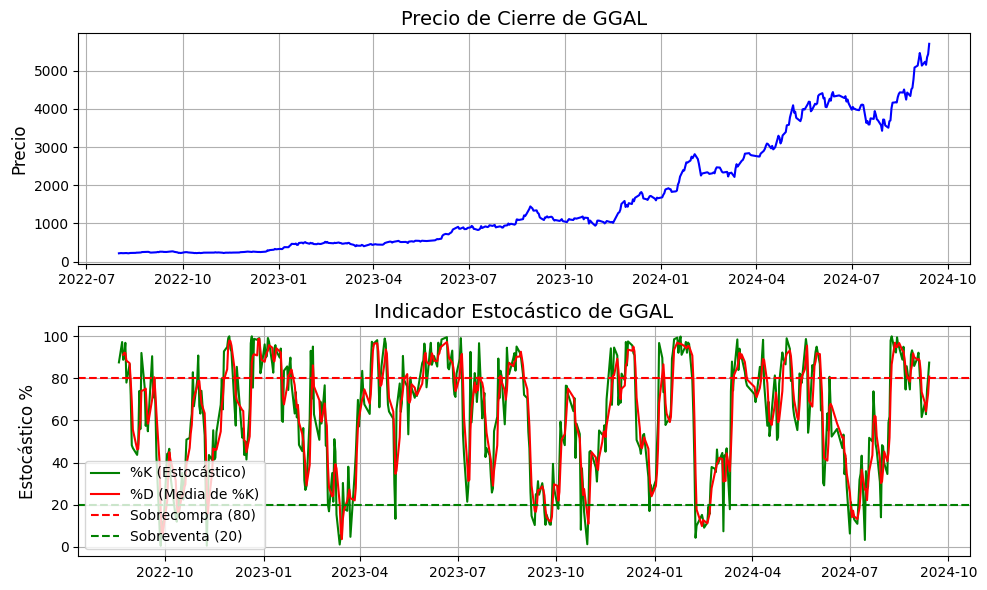

In [21]:
# Calcular el estocástico (Stochastic Oscillator)
periodo_estocastico = 14

# Calcular %K
df_ggal['Lowest_Low'] = df_ggal['low'].rolling(window=periodo_estocastico).min()
df_ggal['Highest_High'] = df_ggal['high'].rolling(window=periodo_estocastico).max()
df_ggal['%K'] = 100 * ((df_ggal['close'] - df_ggal['Lowest_Low']) / (df_ggal['Highest_High'] - df_ggal['Lowest_Low']))

# Calcular %D (media móvil simple de %K)
df_ggal['%D'] = df_ggal['%K'].rolling(window=3).mean()

# Graficar el Estocástico (%K y %D) junto con el precio de cierre
plt.figure(figsize=(10, 6))

# Subplot para el precio de cierre
plt.subplot(2, 1, 1)
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de GGAL', fontsize=14)
plt.ylabel('Precio', fontsize=12)
plt.grid(True)

# Subplot para el indicador estocástico
plt.subplot(2, 1, 2)
plt.plot(df_ggal.index, df_ggal['%K'], label='%K (Estocástico)', color='green')
plt.plot(df_ggal.index, df_ggal['%D'], label='%D (Media de %K)', color='red')
plt.axhline(80, color='red', linestyle='--', label='Sobrecompra (80)')
plt.axhline(20, color='green', linestyle='--', label='Sobreventa (20)')
plt.title('Indicador Estocástico de GGAL', fontsize=14)
plt.ylabel('Estocástico %', fontsize=12)
plt.grid(True)
plt.legend()

# Ajustar el gráfico
plt.tight_layout()
plt.show()

### On-Balance Volume (OBV)

El On-Balance Volume (OBV) es un indicador de momentum que relaciona el volumen con el movimiento de los precios. Se basa en la idea de que el volumen precede a los movimientos de precio, de modo que los cambios en el volumen pueden predecir futuros movimientos del precio.

Cálculo del OBV:
- Si el precio de cierre de hoy es mayor que el de ayer, se suma el volumen de hoy al OBV.
- Si el precio de cierre de hoy es menor que el de ayer, se resta el volumen de hoy al OBV.
- Si el precio de cierre de hoy es igual al de ayer, el OBV permanece sin cambios.
Voy a proceder con el cálculo del OBV para GGAL.

El gráfico del On-Balance Volume (OBV) para GGAL, que muestra la acumulación o disminución del volumen a lo largo del tiempo en relación con los movimientos del precio de cierre.

El OBV puede ser útil para detectar cambios en el volumen que podrían anticipar movimientos del precio.

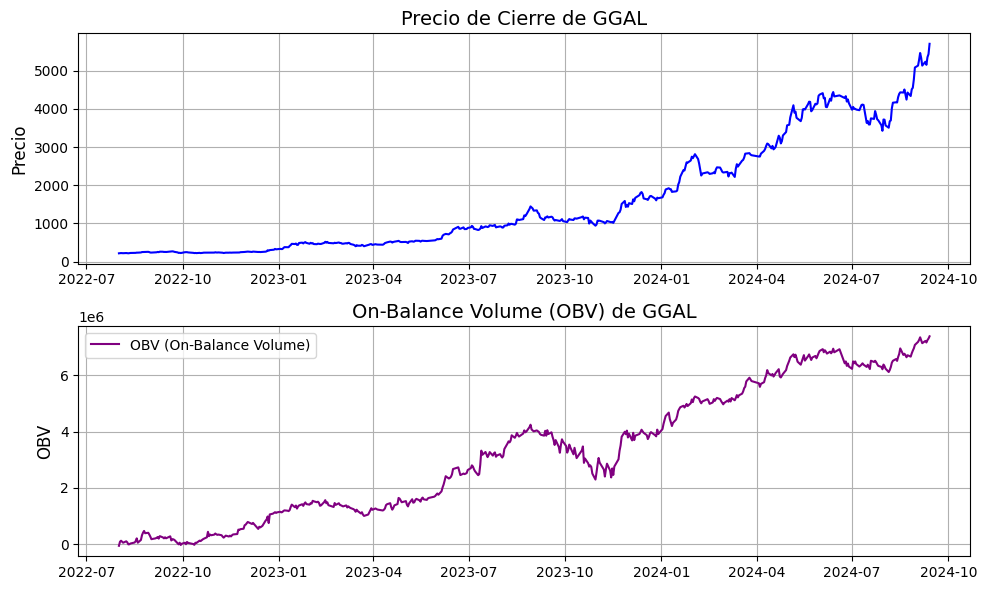

In [22]:
# Calcular el On-Balance Volume (OBV)
df_ggal['OBV'] = 0  # Inicializamos la columna OBV

# Usar una condición para sumar o restar el volumen basado en los cambios en el precio de cierre
df_ggal['OBV'] = df_ggal['volume'].where(df_ggal['close'] > df_ggal['close'].shift(1), -df_ggal['volume'])
df_ggal['OBV'] = df_ggal['OBV'].cumsum()

# Graficar el OBV junto con el precio de cierre
plt.figure(figsize=(10, 6))

# Subplot para el precio de cierre
plt.subplot(2, 1, 1)
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de GGAL', fontsize=14)
plt.ylabel('Precio', fontsize=12)
plt.grid(True)

# Subplot para el OBV
plt.subplot(2, 1, 2)
plt.plot(df_ggal.index, df_ggal['OBV'], label='OBV (On-Balance Volume)', color='purple')
plt.title('On-Balance Volume (OBV) de GGAL', fontsize=14)
plt.ylabel('OBV', fontsize=12)
plt.grid(True)
plt.legend()

# Ajustar el gráfico
plt.tight_layout()
plt.show()

### CCI (Commodity Channel Index)

El CCI (Commodity Channel Index) mide la variación del precio de un activo en relación con su promedio durante un determinado periodo. Se utiliza para identificar posibles puntos de sobrecompra o sobreventa. Un valor de CCI por encima de 100 indica sobrecompra, mientras que un valor por debajo de -100 indica sobreventa.

El gráfico del CCI (Commodity Channel Index) para GGAL, junto con las líneas de referencia de sobrecompra (100) y sobreventa (-100). El CCI es útil para identificar condiciones extremas de mercado que pueden preceder a un cambio en la tendencia.

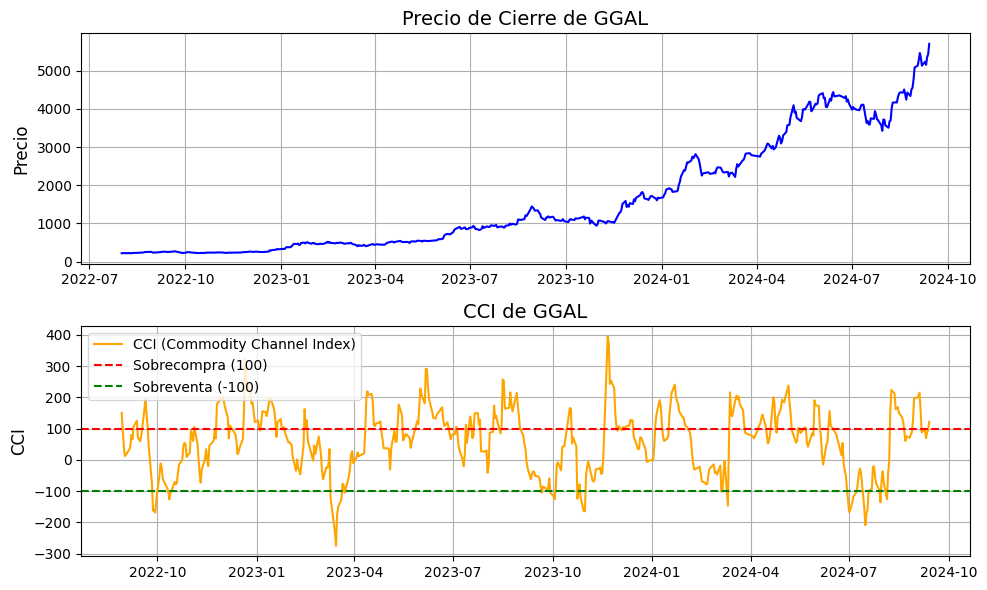

In [23]:
# Calcular el CCI (Commodity Channel Index) con un periodo de 20 días
periodo_cci = 20

# Calcular el precio típico
df_ggal['Typical_Price'] = (df_ggal['high'] + df_ggal['low'] + df_ggal['close']) / 3

# Calcular la media móvil del precio típico
df_ggal['SMA_Typical_Price'] = df_ggal['Typical_Price'].rolling(window=periodo_cci).mean()

# Calcular la desviación estándar del precio típico
df_ggal['Mean_Deviation'] = df_ggal['Typical_Price'].rolling(window=periodo_cci).apply(lambda x: (x - x.mean()).abs().mean())

# Calcular el CCI
df_ggal['CCI'] = (df_ggal['Typical_Price'] - df_ggal['SMA_Typical_Price']) / (0.015 * df_ggal['Mean_Deviation'])

# Graficar el CCI junto con el precio de cierre
plt.figure(figsize=(10, 6))

# Subplot para el precio de cierre
plt.subplot(2, 1, 1)
plt.plot(df_ggal.index, df_ggal['close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de GGAL', fontsize=14)
plt.ylabel('Precio', fontsize=12)
plt.grid(True)

# Subplot para el CCI
plt.subplot(2, 1, 2)
plt.plot(df_ggal.index, df_ggal['CCI'], label='CCI (Commodity Channel Index)', color='orange')
plt.axhline(100, color='red', linestyle='--', label='Sobrecompra (100)')
plt.axhline(-100, color='green', linestyle='--', label='Sobreventa (-100)')
plt.title('CCI de GGAL', fontsize=14)
plt.ylabel('CCI', fontsize=12)
plt.grid(True)
plt.legend()

# Ajustar el gráfico
plt.tight_layout()
plt.show()